In [2]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from shadownet import ShadowNet
from misc import loadModel, crf_refine

In [3]:
class Demo:
    def __init__(self, modelPath = "./models/SBU_5000u.pt"):
        self.net = ShadowNet().cuda()
        loadModel(self.net, modelPath)
        self.net.eval()
    
    def prepare(self, img):
        img = torchvision.transforms.ToTensor()(
            torchvision.transforms.Resize( (320,320) )(
                img
            )
        )
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = torchvision.transforms.Normalize(mean, std)(img)
        return img.unsqueeze(0).cuda()
    
    def postProcess(self, img, pred):
        size = tuple(reversed(img.size))
        pred = torchvision.transforms.ToPILImage()( nn.Sigmoid()( pred["prediction"][0][0] ).cpu() )
        pred = torchvision.transforms.Resize(size)(pred)
        pred_crf = crf_refine(
            np.array(img),
            np.array(pred)
        )
        return pred_crf
    
    def detect(self, img_path):
        img = Image.open(img_path)
        pred = self.net(self.prepare(img))
        pred_crf = self.postProcess(img, pred)
        return img, Image.fromarray(pred_crf)
    

In [4]:
demo = Demo()
img, pred = demo.detect("./samples/1.jpg")
img, pred

d:\Program_Files\Anaconda\envs\detectron2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program_Files\Anaconda\envs\detectron2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to C:\Users\huankguan2/.cache\torch\hub\checkpoints\resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:18<00:00, 19.2MB/s] 


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 <PIL.Image.Image image mode=L size=600x450>)

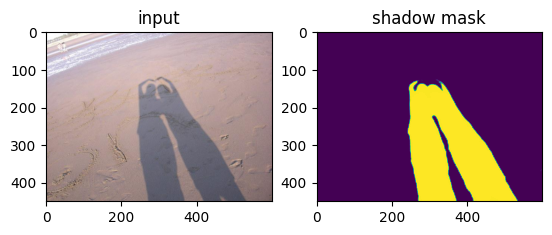

In [5]:
plt.subplot(121)
plt.imshow(img)
plt.title("input")
plt.subplot(122)
plt.imshow(pred)
plt.title("shadow mask")
plt.show()